In [1]:
import pickle
from caiman.utils import visualization
from caiman.source_extraction.cnmf.cnmf import load_CNMF
from pathlib import Path
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import utils as ut

2023-06-07 10:51:21.687154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Batch overview
This notebook reads the results from a batch of preprocessed session and displays statistics and information about them. It can be used to asses the quailty of the preprocessing and pinpoint sessions that need a change in parameters or are not viable for analysis.

In [4]:
# parameters
animals = ['441406_fiano','441394_ribolla']

In [5]:
# print summary of preprocessed data
ut.print_animal_summary('441406_fiano')
ut.print_animal_summary('441394_ribolla')

Overview for 441406_fiano
# of sessions: 24, of which 14 complete


date: 20230413
 NEURAL DATA -cells: nan, rec duration: nan s
 VR DATA -trials: 37, vr duration: 1090.57 s


date: 20230317
 NEURAL DATA -cells: 138, rec duration: 2070.83 s
 VR DATA -trials: 45, vr duration: 2088.58 s


date: 20230330
 NEURAL DATA -cells: 556, rec duration: 1727.43 s
 VR DATA -trials: 41, vr duration: 1745.77 s


date: 20230323
 NEURAL DATA -cells: 251, rec duration: 1923.83 s
 VR DATA -trials: 91, vr duration: 1941.58 s


date: 20230406
 NEURAL DATA -cells: nan, rec duration: nan s
 VR DATA -trials: 49, vr duration: 1779.62 s


date: 20230331
 NEURAL DATA -cells: 231, rec duration: 1689.47 s
 VR DATA -trials: 26, vr duration: 1707.55 s


date: 20230306
 NEURAL DATA -cells: 73, rec duration: 602.73 s
 VR DATA -trials: 7, vr duration: 618.32 s


date: 20230328
 NEURAL DATA -cells: 179, rec duration: 1770.60 s
 VR DATA -trials: 82, vr duration: 1788.95 s


date: 20230405
 NEURAL DATA -cells: nan, rec dur

## Load data

In [98]:
data_path = Path("/ceph/imaging1/davide/2p_data")
sessions = {'441406_fiano':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321',
                           '20230323','20230324','20230328','20230330','2023031'],
            #'441394_ribolla':['20230301','20230306','20230307','20230308','20230309','20230315','20230316','20230317','20230320','20230321']
           }


In [99]:
data = {'animal':[],'date':[],'n_cells':[]}
mean_imgs = []
corr_imgs = []
neural_data = []


for animal in sessions.keys():
    print(f'reading data for animal {animal} ...')
    for date in tqdm(sessions[animal]):
        try:
            with open(data_path.joinpath(f'{animal}/{date}/neural_data.pickle'),'rb') as pfile:
                n_data = pickle.load(pfile)
                neural_data.append(n_data)
            with open(data_path.joinpath(f'{animal}/{date}/metrics.pickle'),'rb') as pfile:
                metrics = pickle.load(pfile)
            mean_imgs.append(np.asarray(metrics['mean_image']))
            corr_imgs.append(np.asarray(metrics['corr_image']))

            data['animal'].append(animal)
            data['date'].append(date)
            data['n_cells'].append(len(n_data['traces']))
        
        except FileNotFoundError:
            print(f'Session {animal}/{date} not preprocesses, skipping')
            continue
        
data = pd.DataFrame(data)


reading data for animal 441406_fiano ...


100%|██████████████████████████████████████████| 15/15 [00:17<00:00,  1.18s/it]

Session 441406_fiano/2023031 not preprocesses, skipping


## Metrics overview

In [104]:
def plot_metrics(i):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.title(f'animal: {data.animal.values[i]}, date : {data.date.values[i]}')
    x = mean_imgs[i]
    plt.imshow(x,vmin=np.percentile(x.ravel(),0.05),vmax=np.percentile(x.ravel(),99.95),cmap=plt.cm.gnuplot2)
    contours = neural_data[i]['contour']
    for c in contours:
        plt.plot(*c.T, c='w')
    
    plt.subplot(1,2,2)
    plt.title(f'number of cells: {data.n_cells.values[i]}')
    x = corr_imgs[i]
    plt.imshow(x,vmin=np.percentile(x.ravel(),3),vmax=np.percentile(x.ravel(),97),cmap=plt.cm.gnuplot2)
    for c in contours:
        plt.plot(*c.T, c='w')
    
    
    

In [105]:
from ipywidgets import interact
import ipywidgets as widgets
interact(plot_metrics, i = widgets.IntSlider(min=0, max=len(mean_imgs), value=0))

interactive(children=(IntSlider(value=0, description='i', max=14), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_metrics(i)>

## Number of detected cells

<Axes: xlabel='n_cells', ylabel='Count'>

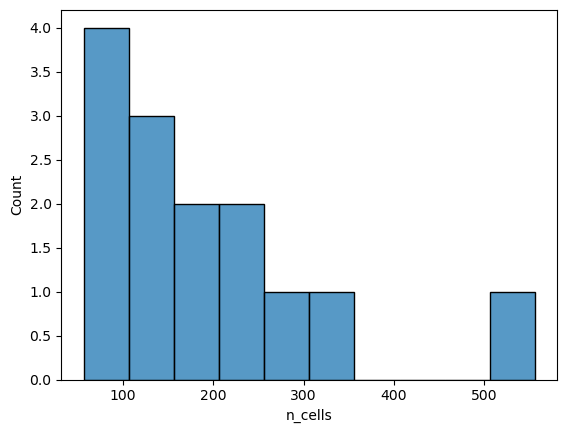

In [100]:
sns.histplot(data=data,x='n_cells',bins=10)

In [48]:
from glob import glob
import pandas as pd
import os

def list_sessions(animal,data_path="/ceph/imaging1/davide/2p_data"):
    session_list = glob(data_path + f'/{animal}/*/', recursive = True)
    
    return session_list

def list_complete_sessions(animal,data_path="/ceph/imaging1/davide/2p_data"):
    session_list = glob(data_path + f'/{animal}/*/', recursive = True)
    complete_sessions = [s for s in session_list if check_complete_session(s)]
    return complete_sessions

def check_neural_data_file(folder_path):
    file_path = os.path.join(folder_path, 'neural_data.pickle')
    return os.path.isfile(file_path)

def check_vr_data_file(folder_path):
    file_path = os.path.join(folder_path, 'behaviour_data.pickle')
    return os.path.isfile(file_path)

def check_trial_data_file(folder_path):
    file_path = os.path.join(folder_path, 'trial_data.csv')
    return os.path.isfile(file_path)

def check_complete_session(folder_path):
    return check_neural_data_file(folder_path) and check_trial_data_file(folder_path) and check_vr_data_file(folder_path)


def print_animal_summary(animal,data_path="/ceph/imaging1/davide/2p_data"):
    '''
    Gives a summary of the preprocessed data for the given animal
    '''
    
    scanner_fps = 30.
    behaviour_fps = 1000.
    
    print(f'Overview for {animal}')
    
    sessions = list_sessions(animal)
    complete_sessions = list_complete_sessions(animal)
    print(f'# of sessions: {len(sessions)}, of which {len(complete_sessions)} complete')
    print('\n')
    
    for s in sessions:
        print(f"date: {s.split('/')[-2]}")
        
        ## NEURAL DATA
        
        try:
            with open(Path(s).joinpath(f'neural_data.pickle'),'rb') as pfile:
                n_data = pickle.load(pfile)
                n_cells = n_data['traces'].shape[0]
                recording_duration =  n_data['traces'].shape[1]/scanner_fps

        except FileNotFoundError:
            n_cells = np.nan
            recording_duration = np.nan
            
        
        ## BEHAVIOUR DATA
        
        try:
            trial_data = pd.read_csv(Path(s).joinpath('trial_data.csv'))
            n_trials = len(trial_data)

        except FileNotFoundError:
            n_trials = np.nan
            
            
        try:
            with open(Path(s).joinpath(f'behaviour_data.pickle'),'rb') as pfile:
                    b_data = pickle.load(pfile)
                    vr_duration = b_data['time'].shape[0]/behaviour_fps
                    
        except FileNotFoundError:
            vr_duration = np.nan
            

        print(f' NEURAL DATA -cells: {n_cells}, rec duration: {recording_duration:.2f} s')
        print(f' VR DATA -trials: {n_trials}, vr duration: {vr_duration:.2f} s')
        print('\n')
        




    

        

In [2]:
ut.print_animal_summary('441406_fiano')

Overview for 441406_fiano
# of sessions: 24, of which 14 complete


date: 20230413
 NEURAL DATA -cells: nan, rec duration: nan s
 VR DATA -trials: 37, vr duration: 1090.57 s


date: 20230317
 NEURAL DATA -cells: 138, rec duration: 2070.83 s
 VR DATA -trials: 45, vr duration: 2088.58 s


date: 20230330
 NEURAL DATA -cells: 556, rec duration: 1727.43 s
 VR DATA -trials: 41, vr duration: 1745.77 s


date: 20230323
 NEURAL DATA -cells: 251, rec duration: 1923.83 s
 VR DATA -trials: 91, vr duration: 1941.58 s


date: 20230406
 NEURAL DATA -cells: nan, rec duration: nan s
 VR DATA -trials: 49, vr duration: 1779.62 s


date: 20230331
 NEURAL DATA -cells: 231, rec duration: 1689.47 s
 VR DATA -trials: 26, vr duration: 1707.55 s


date: 20230306
 NEURAL DATA -cells: 73, rec duration: 602.73 s
 VR DATA -trials: 7, vr duration: 618.32 s


date: 20230328
 NEURAL DATA -cells: 179, rec duration: 1770.60 s
 VR DATA -trials: 82, vr duration: 1788.95 s


date: 20230405
 NEURAL DATA -cells: nan, rec dur

In [51]:
preprocessed_summary('441394_ribolla')

Overview for 441394_ribolla
# of sessions: 24, of which 22 complete


date: 20230413
 NEURAL DATA -cells: 433, rec duration: 1471.87 s
 VR DATA -trials: 36, vr duration: 1487.39 s


date: 20230317
 NEURAL DATA -cells: 498, rec duration: 1999.43 s
 VR DATA -trials: 62, vr duration: 2016.59 s


date: 20230330
 NEURAL DATA -cells: 274, rec duration: 2430.63 s
 VR DATA -trials: 48, vr duration: 2605.51 s


date: 20230323
 NEURAL DATA -cells: nan, rec duration: nan s
 VR DATA -trials: nan, vr duration: nan s


date: 20230406
 NEURAL DATA -cells: 581, rec duration: 1496.10 s
 VR DATA -trials: 24, vr duration: 1791.47 s


date: 20230331
 NEURAL DATA -cells: 254, rec duration: 1984.40 s
 VR DATA -trials: 30, vr duration: 2001.13 s


date: 20230306
 NEURAL DATA -cells: 170, rec duration: 753.20 s
 VR DATA -trials: 4, vr duration: 769.86 s


date: 20230328
 NEURAL DATA -cells: nan, rec duration: nan s
 VR DATA -trials: 39, vr duration: 1691.26 s


date: 20230405
 NEURAL DATA -cells: 190, rec dur